# Import

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pdb
from tqdm.auto import tqdm

/home/amin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
device

device(type='cpu')

# Auxiliary Modules

In [5]:
class Reshape(nn.Module):
  """
  This module reshapes its input to `new_shape`
  """
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape

  def forward(self, x):
    return x.view(-1, *self.new_shape)

class NoiseGenerator(nn.Module):
  """
  This module generates `n` noises with `z_dim` dim from Normal distribution.
  """
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim

  def forward(self, n):
    noise = torch.randn(n, *self.z_dim).to(device)
    return noise

# Helper Functions

In [6]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(start[dim], end[dim], steps))
  result = torch.stack(result, dim=1).to(device)
  return result
  
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = np.ceil(image_batch.shape[0] / rows).astype(int)
  # plt.rcParams['figure.figsize'] = (cols, rows)
  plt.figure(figsize=(1.3*cols, 1.3*rows))

  for i in range(image_batch.shape[0]):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

def img_show(data):
    plt.figure(figsize=(3,3))
    shape = data.shape
    z = data.reshape(shape[1], shape[2])
    plt.imshow(z)
    plt.show()

def mnist_visulization_helper_fn(trainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

def show_interpolations(trainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, -1)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

# Importing Dataset

In [7]:
# np.random.seed()
# torch.manual_seed()
batch_size = 256 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

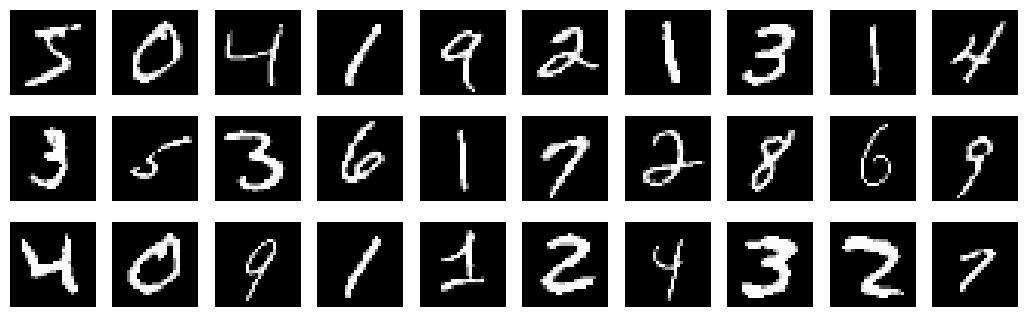

In [8]:
temp = torch.stack([train_dataset[i][0] for i in range(30)], dim=0)
mnist_show(temp, 3)

# Models

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_size = 256):
        self.latent_dim = latent_dim
        self.hidden_size = hidden_size

        super(SimpleGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size*4, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)
    
    def generate_noise(self, batch_size):
        return torch.randn(batch_size, self.latent_dim)

In [11]:
class GeneratorOne(nn.Module):
    def __init__(self, latent_dim, hidden_size):
        super(GeneratorOne, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_size = hidden_size
        self.image_channel = 1

        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(self.latent_dim, self.hidden_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.hidden_size * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(self.hidden_size * 8, self.hidden_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(self.hidden_size * 4, self.hidden_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            # nn.ConvTranspose2d(self.hidden_size * 2, self.hidden_size, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(self.hidden_size),
            # nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(self.hidden_size*2, self.image_channel, 4, 2, 3, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    def generate_noise(self, batch_size):
        return torch.randn(batch_size, self.latent_dim, 1, 1)

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_size):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_size = hidden_size
        self.image_channel = 1
        # self.kernel_size = 2
        self.kernel_size = 4
        self.stride = 2
        self.padding = int(self.kernel_size/2 - 1)

        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(in_channels=self.latent_dim, out_channels = 8 * self.hidden_size, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.BatchNorm2d(8*self.hidden_size),
            nn.Dropout2d(p=0.2),
            nn.LeakyReLU(0.2),

            # # 1st hidden layer
            nn.ConvTranspose2d(8 * self.hidden_size, 4 * self.hidden_size, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.BatchNorm2d(4 * self.hidden_size),
            nn.Dropout2d(p=0.2),
            nn.LeakyReLU(0.2),
            
            # 2nd hidden layer
            nn.ConvTranspose2d(4 * self.hidden_size, 2 * self.hidden_size, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.BatchNorm2d(2 * self.hidden_size),
            nn.Dropout2d(p=0.2),
            nn.LeakyReLU(0.2),
            
            # 3rd hidden layer
            nn.ConvTranspose2d(2 * self.hidden_size, self.hidden_size, kernel_size=self.kernel_size, stride=self.stride, padding=1),
            nn.BatchNorm2d(self.hidden_size),
            nn.Dropout2d(p=0.2),
            nn.LeakyReLU(0.2),
            
            # output layer
            nn.ConvTranspose2d(self.hidden_size, self.image_channel, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
    def generate_noise(self, batch_size):
        return torch.randn(batch_size, self.latent_dim, 1, 1)

In [13]:
g = Generator(100, 128)

In [74]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.main(x)

# Train

In [76]:
criterion = nn.BCELoss()

latent_dim = 100
# hidden_size = 20
# generator = Generator(latent_dim, 20).to(device)

# hidden_size = 256
# generator = SimpleGenerator(latent_dim, hidden_size).to(device)

generator = GeneratorOne(latent_dim, 256).to(device)

discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

learning_rate = 0.001
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)


g_learning_times = 3
d_leaning_times = 1

num_epochs = 10
for epoch in range(num_epochs):

    for n, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        current_batch_size = images.size(0)

        # Train discriminator
        for t in range(d_leaning_times):
            optimizer_d.zero_grad()
            
            # Real images
            real_outputs = discriminator(images)
            real_labels = torch.ones(current_batch_size, 1).to(device)
            real_loss = criterion(real_outputs, real_labels)

            # Fake images
            noise = generator.generate_noise(current_batch_size)
            fake_images = generator(noise)
            # pdb.set_trace()
            fake_outputs = discriminator(fake_images.detach())
            fake_labels = torch.zeros(current_batch_size, 1).to(device)
            fake_loss = criterion(fake_outputs, fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

        # Train generator
        for t in range(g_learning_times):
            optimizer_g.zero_grad()
            
            noise = generator.generate_noise(current_batch_size)
            fake_images = generator(noise)
            outputs = discriminator(fake_images)
            
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()
        
    
        if (n+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{n+1}/{len(train_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_outputs.mean().item():.2f}, D(G(z)): {fake_outputs.mean().item():.2f}')

KeyboardInterrupt: 

# Visualize

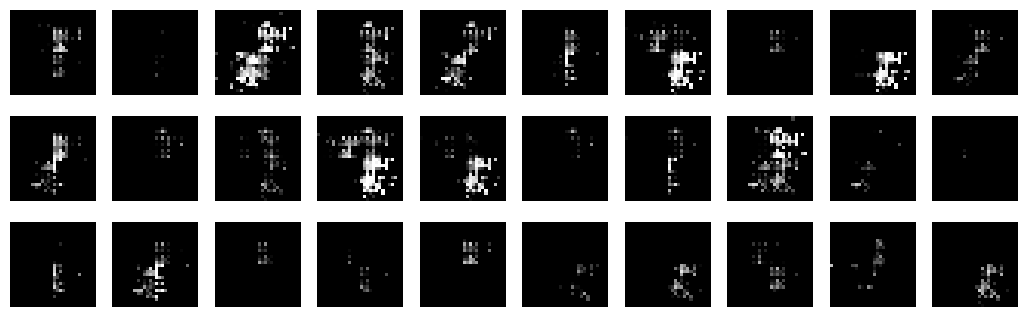

In [239]:
noise = generator.generate_noise(30)
fake_images = generator(noise)
mnist_show(fake_images, 3)